## Import Necessary Packages

In [1]:
import warnings
import numpy as np
import xarray as xr
import proplot as pplt
import matplotlib.patches as patches
pplt.rc.reso='hi'
warnings.filterwarnings('ignore')

## User-Defined Fields

In [25]:
REGIONS   = {
    'Eastern Arabian Sea':{'latmin':9.,'latmax':18.,'lonmin':67.,'lonmax':72.5}, 
    'Central India':{'latmin':18.,'latmax':24.,'lonmin':76.,'lonmax':83.},
    'Northern Bay of Bengal':{'latmin':18.,'latmax':21.5,'lonmin':87.5,'lonmax':90.},
    'Central Bay of Bengal':{'latmin':8.5,'latmax':15.,'lonmin':86.,'lonmax':90.}} 
FILEDIR   = '/ocean/projects/atm200007p/sferrett/Repos/monsoon-pr/data/raw'
SAVEDIR   = '/ocean/projects/atm200007p/sferrett/Repos/monsoon-pr/figs'
LATRANGE  = (5.,25.)
LONRANGE  = (60.,90.)
STDTHRESH = 75.

## Import Data

In [26]:
def open_dataset(filename,filedir=FILEDIR):
    filepath = f'{filedir}/{filename}'
    ds = xr.open_dataset(filepath)
    return ds

In [27]:
data = open_dataset('IMERG_precipitation_flux.nc')

## Get Monthly Means and Standard Deviations

In [28]:
pr  = data.pr.groupby('time.month').mean(dim='time')
std = data.pr.groupby('time.month').std(dim='time')

In [29]:
prdiff  = pr.isel(month=1)-pr.isel(month=0)
stdmask = std > np.percentile(std,STDTHRESH)

## Plot

In [30]:
def format_axs(axs):
    axs.format(
        collabels=['June','July','August','July - June'],
        coast=True,
        latlim=LATRANGE,
        latlines=5,
        lonlim=LONRANGE,
        lonlines=5,
        lonlabels=True)
    axs[0].format(latlabels=True)

def make_patch(lonmin,lonmax,latmin,latmax):
    patchkwargs = dict(edgecolor='k',facecolor='none',linewidth=1)
    return patches.Rectangle((lonmin,latmin),lonmax-lonmin,latmax-latmin,**patchkwargs)

def add_region_patches(axs,patchkwargs,regions=REGIONS):
    for region in regions.values():
        for ax in axs:
            ax.add_patch(make_patch(region['lonmin'],region['lonmax'],region['latmin'],region['latmax']))

def plot_monthly_pr(axs,pr,mask,prkwargs,maskkwargs):
    for i,ax in enumerate(axs):
        monthlypr   = pr.isel(month=i)
        monthlymask = np.ma.masked_where(~mask.isel(month=i),monthlypr)
        m = ax.contourf(monthlypr,**prkwargs)
        ax.contourf(monthlymask,**maskkwargs)
    axs[-1].colorbar(m,loc='r',ticks=6,label='Precipitation (mm/day)')

def plot_diff(ax,prdiff,diffkwargs,divkwargs):
    m = ax.contourf(prdiff,**diffkwargs)
    ax.contour(prdiff,**divkwargs)
    ax.colorbar(m,loc='r',ticks=3,label='$\Delta$Precipitation (mm/day)')

In [31]:
patchkwargs = dict(edgecolor='k',facecolor='none',linewidth=1)
prkwargs    = dict(cmap='Mako_r',vmin=0,vmax=30,levels=21,extend='max')
maskkwargs  = dict(levels=[0,np.max(pr)],hatches=['///////'],alpha=0,colors='none')
diffkwargs  = dict(cmap='DryWet',vmin=-10,vmax=10,levels=24,extend='both')
divkwargs   = dict(levels=[0],color='k',linewidth=0.5,linestyle='--')

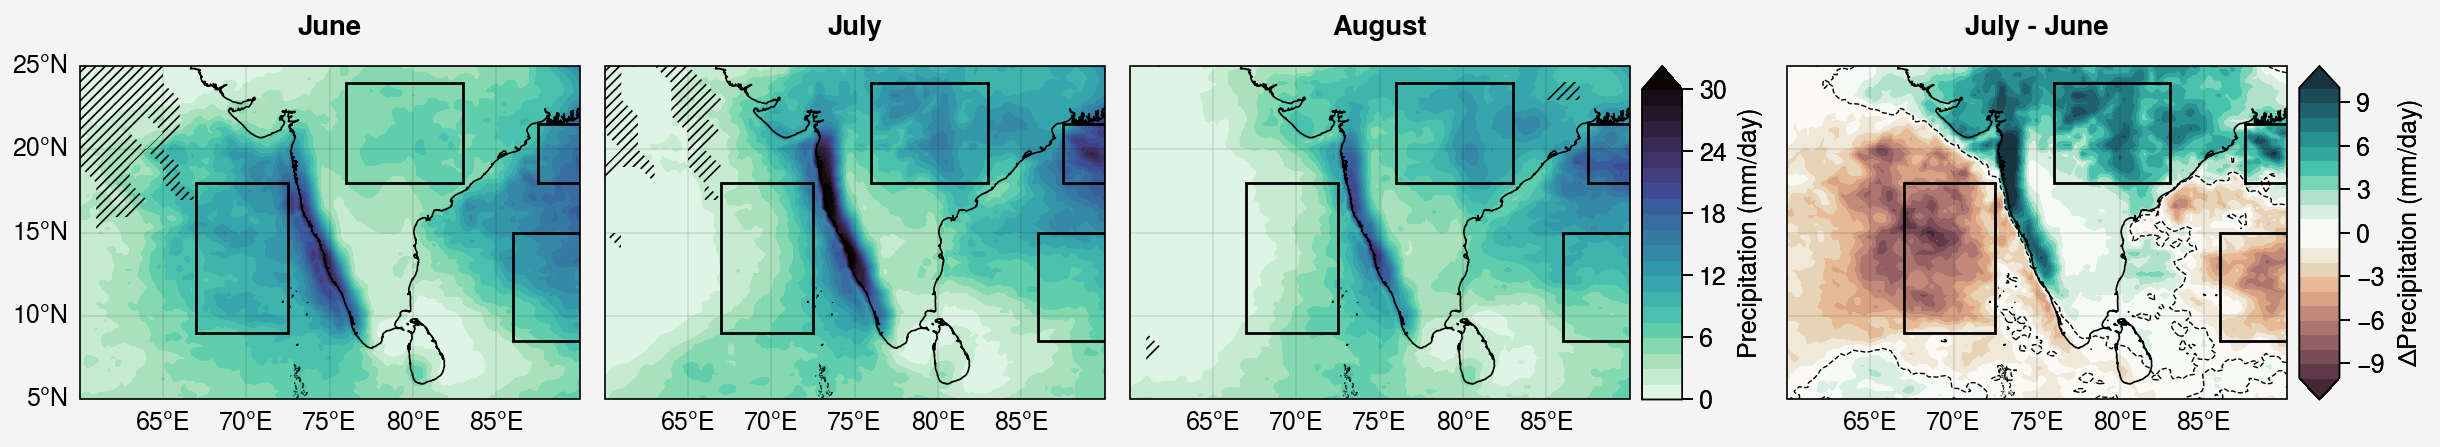

In [33]:
fig,axs = pplt.subplots(nrows=1,ncols=4,proj='cyl')
format_axs(axs)
add_region_patches(axs,patchkwargs)
plot_monthly_pr(axs[:3],pr,stdmask,prkwargs,maskkwargs)
plot_diff(axs[3],prdiff,diffkwargs,divkwargs)
pplt.show()
fig.save(f'{SAVEDIR}/fig_1.png',dpi=300)